In [ ]:
#temp test
img_path_to_crop_features = [v for k,v in class_idx_to_paths_to_crop_features.items()]
crop_vector_list = [v for dictionary in img_path_to_crop_features for k,v in dictionary.items()]
crop_vector_list = torch.cat(crop_vector_list)
    
description_feature_vector_list = [v for k,v in class_idx_to_description_features.items()]
description_feature_vector_list = torch.cat(description_feature_vector_list)
    
#calculate dot product of every feature vector to every feature vector
similarity_matrix = torch.mm(crop_vector_list,description_feature_vector_list.T)
top_1_predictions = similarity_matrix.max(dim=1).indices // n_descriptions_per_class
top_1_predictions_mj_vote = torch.mode(top_1_predictions.view(-1,run_params['imp_samp_params']['patches_per_image']),dim=1).values

In [1]:
import clip
import torch
from torch.functional import F
import torchvision
import numpy as np
import os
import PIL
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import imp_samp

/export/home/lrietdor/miniconda3/envs/Hiwi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cuda_device = "cuda:7"

In [3]:
i = 0
while os.path.exists(f"/export/home/lrietdor/hiwi/bayer_microbiology/plots_big_ds_big_ss{i}"):
    i += 1

SAVE_PATH = f"/export/home/lrietdor/hiwi/bayer_microbiology/plots_big_ds_big_ss{i}"
os.makedirs(SAVE_PATH, exist_ok=True)

PATH_TO_DS = "/export/compvis-nfs/group/datasets/microbiology_big/images_png"

log_path = os.path.join(SAVE_PATH, "log.txt")
#create log file
with open(log_path, "w") as f:
    f.write("log file\n")

elems_in_dir = os.listdir(PATH_TO_DS)
elems_in_dir = [d for d in elems_in_dir if os.path.isdir(os.path.join(PATH_TO_DS, d)) and not d.startswith("6")]  #we don't have descriptions for idx 6 so far (name: CRYSTAL)
elems_in_dir = sorted(elems_in_dir)

class_idx_to_img_paths = {}
for dir in elems_in_dir:
    class_idx_to_img_paths[dir] = [os.path.join(PATH_TO_DS,dir,elem) for elem in os.listdir(os.path.join(PATH_TO_DS, dir)) if elem.endswith(".png")]

In [4]:
with open("/export/compvis-nfs/group/datasets/microbiology_big/jsons/idx_to_classname.json", "r") as f:
    idx_to_classname = json.load(f)
classnames = list(idx_to_classname.values())
classnames_in_description_format = {i:[classname for _ in range(5)] for i,classname in enumerate(classnames)}

with open("/export/compvis-nfs/group/datasets/microbiology_big/jsons/idx_to_descriptions.json", "r") as f:
    idx_to_descriptions = json.load(f)

def get_sentence_descriptions(idx_to_classname, idx_to_descriptions):
    descriptions = {}
    def build_descriptions(classname,category,description):
        return f"{classname} whose {category} is {description}"
    for idx in range(len(idx_to_classname)):
        descriptions[idx] = [build_descriptions(idx_to_classname[str(idx)], category, description) for category, description in idx_to_descriptions[str(idx)].items()]
    return descriptions
def get_raw_descriptions(idx_to_classname, idx_to_descriptions):
    descriptions = {}
    for idx in range(len(idx_to_classname)):
        descriptions[idx] = [description for category, description in idx_to_descriptions[str(idx)].items()]
    return descriptions

class_idx_to_sentence_descriptions = get_sentence_descriptions(idx_to_classname, idx_to_descriptions)
class_idx_to_raw_descriptions = get_raw_descriptions(idx_to_classname, idx_to_descriptions)

In [5]:
def sample_random_image_paths_per_class(dataset_paths, n_samples_per_class):
    sampled_paths = {}
    for key in dataset_paths.keys():
        sampled_paths[key] = random.sample(dataset_paths[key], n_samples_per_class)
    return sampled_paths

n_image_samples_per_class = 10
class_idx_to_sampled_img_paths = sample_random_image_paths_per_class(class_idx_to_img_paths, n_image_samples_per_class)

In [7]:
def sample_important_crops_per_image(class_idx_to_sampled_img_paths, n_crops,imp_samp_params):
    class_idx_to_sampled_img_paths_to_sampled_crops = {}
    for idx, path_list in class_idx_to_sampled_img_paths.items():
        class_idx_to_sampled_img_paths_to_sampled_crops[idx] = {path: [] for path in path_list}
        for image_path in path_list:
            crop_list=[]
            patcher = imp_samp.Patcher(image_path=image_path, **imp_samp_params)
            for i in range(n_crops):
                crop = next(patcher)
                crop_list.append(crop)
            class_idx_to_sampled_img_paths_to_sampled_crops[idx][image_path] = crop_list
    return class_idx_to_sampled_img_paths_to_sampled_crops
            

def sample_random_crops_per_image(class_idx_to_sampled_img_paths, n_crops):
    class_idx_to_sampled_img_paths_to_sampled_crops = {}
    for idx, path_list in class_idx_to_sampled_img_paths.items():
        class_idx_to_sampled_img_paths_to_sampled_crops[idx] = {path: [] for path in path_list}
        for path in path_list:
            crop_list = []
            img = PIL.Image.open(path)
            for i in range(n_crops):
                crop = torchvision.transforms.RandomCrop(512)(img)
                crop_list.append(crop)
            class_idx_to_sampled_img_paths_to_sampled_crops[idx][path] = crop_list
    return class_idx_to_sampled_img_paths_to_sampled_crops

IMP_SAMP = True

log = f"IMP_SAMP: {IMP_SAMP} \n"
with open(log_path, "a") as f:
    f.write(log)

n_crops_per_image = 7
imp_samp_params = {
    "patch_size": 256,
    "reduce_factor": 1,
    "scale_dog": 1,
    "grid_sep": 128,
    "map_type": "importance",
    "patches_per_image": n_crops_per_image,
    "blur_samp_map": False,
    "seed": 123
}

if IMP_SAMP:
    log = f"Using importance sampling with parameters: {imp_samp_params} \n"
    with open(log_path, "a") as f:
        f.write(log)

class_idx_to_paths_to_sampled_crops = sample_important_crops_per_image(class_idx_to_sampled_img_paths, n_crops_per_image,imp_samp_params) if IMP_SAMP else sample_random_crops_per_image(class_idx_to_sampled_img_paths, n_crops_per_image)

In [12]:
class_idx_to_paths_to_sampled_crops

{'0': {'/export/compvis-nfs/group/datasets/microbiology_big/images_png/0/E1_P7_G05_f9.png': [<PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>],
  '/export/compvis-nfs/group/datasets/microbiology_big/images_png/0/E1_P7_G04_f4.png': [<PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Image image mode=L size=256x256>],
  '/export/compvis-nfs/group/datasets/microbiology_big/images_png/0/E1_PP7_C04_f5.png': [<PIL.Image.Image image mode=L size=256x256>,
   <PIL.Image.Ima

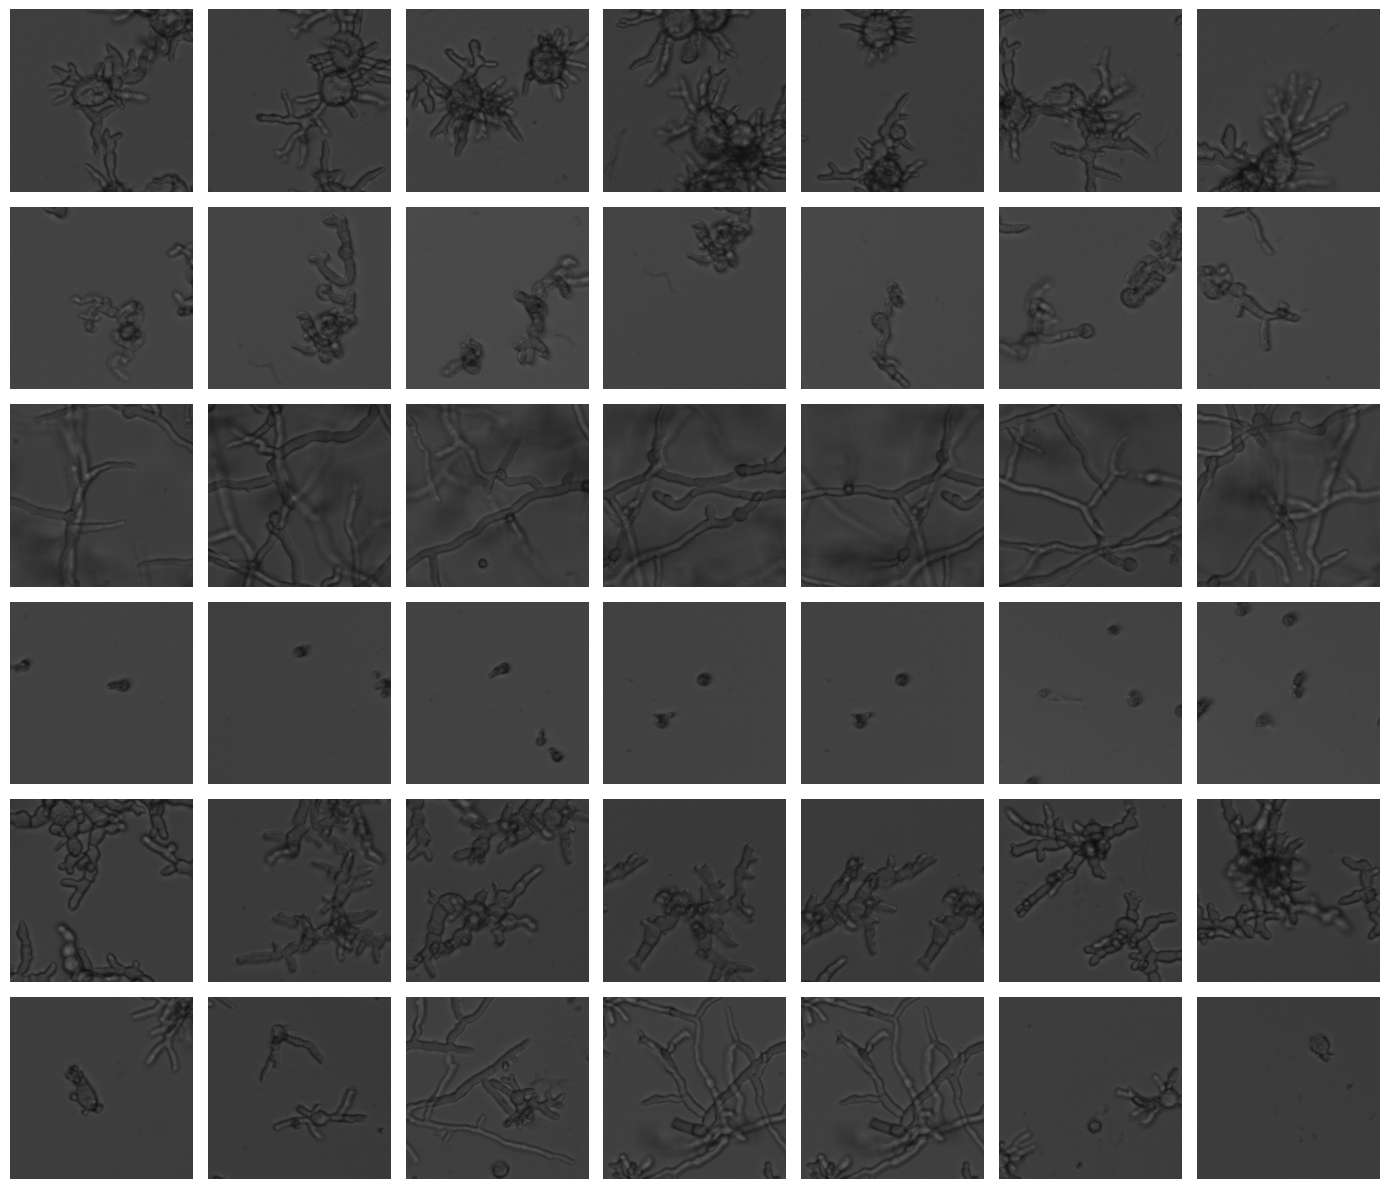

In [23]:
SHOW = True
if SHOW:
    fig, axes = plt.subplots(6, 7, figsize=(14, 12))
    for idx in class_idx_to_paths_to_sampled_crops.keys():
        a = list(class_idx_to_paths_to_sampled_crops[idx].values())[0]
        for i,patch in enumerate(a):
            axes[int(idx),i].imshow(patch.convert("RGB"))
            axes[int(idx),i].axis('off')

    plt.tight_layout()
    plt.show()

In [19]:
open_ai_backbone_names = ["ViT-B/32", "ViT-B/16", "ViT-L/14","ViT-L/14@336px"]
# in the beginning, just use the first one
open_ai_backbone = open_ai_backbone_names[0]
backbone,preprocess = clip.load(open_ai_backbone, device="cuda:7")


### Encoding Functions

In [20]:
def get_normalized_image_encoding(img, backbone, preprocess,cuda_device):
    with torch.no_grad():
        image_input = preprocess(img).unsqueeze(0).to(cuda_device)
        image_features = backbone.encode_image(image_input)
        image_features = F.normalize(image_features, dim=-1) #is this the right dimensionality?
    return image_features

def get_class_idx_to_image_features(class_idx_to_sampled_img_paths, backbone, preprocess,cuda_device):
    class_idx_to_image_features = {}
    for idx, sampled_image_paths in tqdm.tqdm(class_idx_to_sampled_img_paths.items()):
        acc = []
        for path in sampled_image_paths:
            img = PIL.Image.open(path)
            img_features = get_normalized_image_encoding(img, backbone, preprocess,cuda_device)
            img_features = img_features.squeeze(0)
            acc.append(img_features)
        class_idx_to_image_features[idx] = torch.stack(acc)
    return class_idx_to_image_features

def get_class_idx_to_paths_to_crop_features(class_idx_to_paths_to_sampled_crops, backbone, preprocess,cuda_device):
    class_idx_to_paths_to_crop_features = {}
    for idx, path_to_crops in tqdm.tqdm(class_idx_to_paths_to_sampled_crops.items()):
        class_idx_to_paths_to_crop_features[idx] = {}
        for path, crops in path_to_crops.items():
            acc = []
            for crop in crops:
                crop_features = get_normalized_image_encoding(crop, backbone, preprocess,cuda_device)
                crop_features = crop_features.squeeze(0)
                acc.append(crop_features)
            class_idx_to_paths_to_crop_features[idx][path] = torch.stack(acc)
    return class_idx_to_paths_to_crop_features

In [21]:
def get_normalized_text_encoding(text, backbone, cuda_device):
    with torch.no_grad():
        text_input = clip.tokenize([text]).to(cuda_device)
        text_features = backbone.encode_text(text_input)
        text_features = F.normalize(text_features, dim=-1)
    return text_features
def get_class_idx_to_description_features(descriptions, backbone, cuda_device):
    class_idx_to_description_features = {}
    for idx, descriptions in tqdm.tqdm(descriptions.items()):
        acc = []
        for description in descriptions:
            description_features = get_normalized_text_encoding(description, backbone, cuda_device)
            description_features = description_features.squeeze(0)
            acc.append(description_features)
        class_idx_to_description_features[idx] = torch.stack(acc)
    return class_idx_to_description_features

In [22]:
sentence_description_features = get_class_idx_to_description_features(class_idx_to_sentence_descriptions, backbone, cuda_device)
raw_description_features = get_class_idx_to_description_features(class_idx_to_raw_descriptions, backbone, cuda_device)
classname_features = get_class_idx_to_description_features(classnames_in_description_format, backbone, cuda_device)

100%|██████████| 6/6 [00:00<00:00, 27.96it/s]


In [23]:

class_idx_to_image_features = get_class_idx_to_image_features(class_idx_to_sampled_img_paths, backbone, preprocess,cuda_device)

100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


In [24]:
class_idx_to_paths_crop_features = get_class_idx_to_paths_to_crop_features(class_idx_to_paths_to_sampled_crops, backbone, preprocess,cuda_device)

100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


## Plotting Functions

In [25]:
def save_heatmap_from_df (df,save_path,info_dict,figsize=(12,10), title="Heatmap",tight=True,axis_labels=["Class Index","Class Index"]):
    #mask = np.triu(np.ones_like(df, dtype=bool))
    plt.figure(figsize=figsize)
    sns.heatmap(df, cmap='jet')
    plt.title(title, fontsize=20)
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[1])
    info_text = "\n".join([f"{k}: {v}" for k,v in info_dict.items()])
    plt.text(1.25, 0.04, info_text, horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
    if tight:
        plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Image-based View

## Img2Img Similarity

### No Aggregation

In [26]:
def get_img_to_img_sim_heatmap(class_idx_to_image_features,file_name,title,info_dict,axis_captions):
    
    feature_vector_list = [v for k,v in class_idx_to_image_features.items()]
    
    feature_vector_list = torch.cat(feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(feature_vector_list,feature_vector_list.T).cpu().numpy()
       
    axis_labels = [[label for _ in range(n_image_samples_per_class)] for label in list(class_idx_to_image_features.keys())]
    axis_labels_flattened = [item for sublist in axis_labels for item in sublist]
    df = pd.DataFrame(similarity_matrix,columns=axis_labels_flattened,index=axis_labels_flattened)
    save_path = os.path.join(SAVE_PATH,file_name)
    fig_size = (14,14)
    tight=True
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,tight,axis_captions)

In [27]:
get_img_to_img_sim_heatmap(class_idx_to_image_features,"img_to_img_sim_heatmap.png",title="Image to Image Similarity Heatmap",info_dict=idx_to_classname,axis_captions=["Image Class Index","Image Class Index"])

### Aggregation: Class-level average

In [28]:
def get_img_to_img_sim_class_avg_heatmap(class_idx_to_image_features,file_name,title,info_dict,axis_captions):
    
    feature_vector_list = [v for k,v in class_idx_to_image_features.items()]
    
    feature_vector_list = torch.cat(feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(feature_vector_list,feature_vector_list.T).cpu().numpy()
    #now average in groups of n_image_samples_per_class
    similarity_matrix_avg = similarity_matrix.reshape(len(class_idx_to_image_features),n_image_samples_per_class,len(class_idx_to_image_features),n_image_samples_per_class).mean(axis=(1,3))

       
    axis_labels = [label for label in list(class_idx_to_image_features.keys())]
    
    df = pd.DataFrame(similarity_matrix_avg,columns=axis_labels,index=axis_labels)
    save_path = os.path.join(SAVE_PATH,file_name)
    fig_size = (14,14)
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,axis_captions)

In [29]:
get_img_to_img_sim_class_avg_heatmap(class_idx_to_image_features,"img_to_img_sim_class_avg_heatmap.png",title="Image to Image Class Average Similarity Heatmap",info_dict=idx_to_classname,axis_captions=["Image Avg Class Index","Image Avg Class Index"])

## Img2Lang Similarity

### No Aggregation

In [30]:
def get_img_to_lang_sim_heatmap(class_idx_to_image_features, class_idx_to_description_features, file_name, title, info_dict, tight,lang_base,fig_size=(10,50),axis_labels=["Class Index","Class Index"],axis_flip=False):
    
    image_feature_vector_list = [v for k,v in class_idx_to_image_features.items()]
    image_feature_vector_list = torch.cat(image_feature_vector_list)
    
    description_feature_vector_list = [v for k,v in class_idx_to_description_features.items()]
    description_feature_vector_list = torch.cat(description_feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(image_feature_vector_list,description_feature_vector_list.T).cpu().numpy()
    img_labels = [[label for _ in range(n_image_samples_per_class)] for label in list(class_idx_to_image_features.keys())]
    img_labels_flattened = [item for sublist in img_labels for item in sublist]
    lang_labels_flattened = [item for key, sublist in lang_base.items() for item in sublist]
    df = pd.DataFrame(similarity_matrix,columns=lang_labels_flattened,index=img_labels_flattened)
    if "classname" in file_name:
        df = df.iloc[:,::5]
    if axis_flip:
        df = df.T
        axis_labels = [axis_labels[1],axis_labels[0]]
    save_path = os.path.join(SAVE_PATH,file_name)
    fig_size = fig_size
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,tight,axis_labels)


In [31]:
get_img_to_lang_sim_heatmap(class_idx_to_image_features, sentence_description_features, "img_to_sen_des_sim_heatmap.png", title="Image to Sentence Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_sentence_descriptions,fig_size=(25,10),axis_labels=["String","Image Class Index"],axis_flip=True)

In [32]:
get_img_to_lang_sim_heatmap(class_idx_to_image_features, raw_description_features, "img_to_raw_des_sim_heatmap.png", title="Image to Raw Description Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_raw_descriptions,fig_size=(25,10),axis_labels=["String","Image Class Index"],axis_flip=True)

In [33]:
get_img_to_lang_sim_heatmap(class_idx_to_image_features, classname_features, "img_to_classname_sim_heatmap.png", title="Image to Classname Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=classnames_in_description_format,fig_size=(20,10),axis_labels=["String","Image Class Index"],axis_flip=True)

### Aggregation: Class-level average

In [34]:
def get_img_to_lang_sim_class_avg_heatmap(class_idx_to_image_features, class_idx_to_description_features, file_name, title, info_dict, tight,lang_base,fig_size=(10,50),axis_labels=["Class Index","Class Index"],axis_flip=False):
    image_feature_vector_list = [v for k,v in class_idx_to_image_features.items()]
    image_feature_vector_list = torch.cat(image_feature_vector_list)
    
    description_feature_vector_list = [v for k,v in class_idx_to_description_features.items()]
    description_feature_vector_list = torch.cat(description_feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(image_feature_vector_list,description_feature_vector_list.T).cpu().numpy()
    n_des_features_per_class = len(list(class_idx_to_description_features.values())[0])
    #now average in groups of n_image_samples_per_class
    similarity_matrix_avg = similarity_matrix.reshape(len(class_idx_to_image_features),n_image_samples_per_class,len(class_idx_to_description_features),n_des_features_per_class).mean(axis=(1,3))
    img_labels = [label for label in list(class_idx_to_image_features.keys())]
    lang_labels = [key for key, sublist in lang_base.items()]
    df = pd.DataFrame(similarity_matrix_avg,columns=lang_labels,index=img_labels)
    #if "classname" in file_name:
     #   df = df.iloc[:,::5]
    if axis_flip:
        df = df.T
        axis_labels = [axis_labels[1],axis_labels[0]]
    save_path = os.path.join(SAVE_PATH,file_name)
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,tight,axis_labels)

In [35]:
get_img_to_lang_sim_class_avg_heatmap(class_idx_to_image_features, sentence_description_features, "img_to_sen_des_sim_class_avg_heatmap.png", title="Image to Sentence Class Average Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_sentence_descriptions,fig_size=(13,10),axis_labels=["String","Class Index"],axis_flip=True)

In [36]:
get_img_to_lang_sim_class_avg_heatmap(class_idx_to_image_features, raw_description_features, "img_to_raw_des_sim_class_avg_heatmap.png", title="Image to Raw Description Class Average Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_raw_descriptions,fig_size=(13,10),axis_labels=["String","Class Index"],axis_flip=True)

In [37]:
get_img_to_lang_sim_class_avg_heatmap(class_idx_to_image_features, classname_features, "img_to_classname_sim_class_avg_heatmap.png", title="Image to Classname Class Average Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=classnames_in_description_format,fig_size=(13,10),axis_labels=["String","Class Index"],axis_flip=True)

# Patch-based View

## Patch2Patch Similarity

### No Aggregation

In [38]:
def get_patch_to_patch_sim_heatmap(class_idx_to_paths_to_crop_features,file_name,title,info_dict,tight,fig_size=(10,50),axis_captions=["Class Index","Class Index"],axis_flip=False):
    
    img_path_to_crop_features = [v for k,v in class_idx_to_paths_to_crop_features.items()]
    
    feature_vector_list = [v for dictionary in img_path_to_crop_features for k,v in dictionary.items()]
    
    feature_vector_list = torch.cat(feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(feature_vector_list,feature_vector_list.T).cpu().numpy()
       
    axis_labels = [[label for _ in range(n_image_samples_per_class*n_crops_per_image)] for label in list(class_idx_to_paths_crop_features.keys())]
    axis_labels_flattened = [item for sublist in axis_labels for item in sublist]
    df = pd.DataFrame(similarity_matrix,columns=axis_labels_flattened,index=axis_labels_flattened)
    #if "classname" in file_name:
     #   df = df.iloc[:,::5]
    if axis_flip:
        df = df.T
        axis_labels = [axis_labels[1],axis_labels[0]]
    save_path = os.path.join(SAVE_PATH,file_name)
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,tight,axis_captions)

In [39]:
get_patch_to_patch_sim_heatmap(class_idx_to_paths_crop_features,"patch_to_patch_sim_heatmap.png",title="Patch to Patch Similarity Heatmap",info_dict=idx_to_classname,tight=True,fig_size=(12,12),axis_captions=["Patch Class Index","Patch Class Index"],axis_flip=False)

### Aggregation: Image_level average

In [40]:
def get_patch_to_patch_sim_image_avg_heatmap(class_idx_to_paths_to_crop_features,file_name,title,info_dict,axis_captions):
    
    img_path_to_crop_features = [v for k,v in class_idx_to_paths_to_crop_features.items()]
    
    feature_vector_list = [v for dictionary in img_path_to_crop_features for k,v in dictionary.items()]
    
    feature_vector_list = torch.cat(feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(feature_vector_list,feature_vector_list.T).cpu().numpy()
    #now average in groups of n_crop_per_image
    similarity_matrix_avg = similarity_matrix.reshape(len(class_idx_to_paths_to_crop_features),n_image_samples_per_class,n_crops_per_image,len(class_idx_to_paths_to_crop_features),n_image_samples_per_class,n_crops_per_image).mean(axis=(2,5))
    similarity_matrix_avg = similarity_matrix_avg.reshape(len(class_idx_to_paths_to_crop_features)*n_image_samples_per_class,len(class_idx_to_paths_to_crop_features)*n_image_samples_per_class)
       
    axis_labels = [[label for _ in range(n_image_samples_per_class)] for label in list(class_idx_to_paths_crop_features.keys())]
    axis_labels_flattened = [item for sublist in axis_labels for item in sublist]
    df = pd.DataFrame(similarity_matrix_avg,columns=axis_labels_flattened,index=axis_labels_flattened)
    save_path = os.path.join(SAVE_PATH,file_name)
    fig_size = (14,14)
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,axis_captions)

In [41]:
get_patch_to_patch_sim_image_avg_heatmap(class_idx_to_paths_crop_features,"patch_to_patch_sim_image_avg_heatmap.png",title="Patch to Patch Image Average Similarity Heatmap",info_dict=idx_to_classname,axis_captions=["Image Avg Class Index","Image Avg Class Index"])

### Aggregation: Class-level average

In [42]:
def get_patch_to_patch_sim_class_avg_heatmap(class_idx_to_paths_to_crop_features,file_name,title,info_dict,axis_captions):
    
    img_path_to_crop_features = [v for k,v in class_idx_to_paths_to_crop_features.items()]
    
    feature_vector_list = [v for dictionary in img_path_to_crop_features for k,v in dictionary.items()]
    
    feature_vector_list = torch.cat(feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(feature_vector_list,feature_vector_list.T).cpu().numpy()
    #now average in groups of n_crop_per_image
    similarity_matrix_avg = similarity_matrix.reshape(len(class_idx_to_paths_to_crop_features),n_image_samples_per_class,n_crops_per_image,len(class_idx_to_paths_to_crop_features),n_image_samples_per_class,n_crops_per_image).mean(axis=(2,5))
    similarity_matrix_avg = similarity_matrix_avg.mean(axis=(1,3))
       
    axis_labels = [label for label in list(class_idx_to_paths_crop_features.keys())]
    axis_labels_flattened = [item for sublist in axis_labels for item in sublist]
    df = pd.DataFrame(similarity_matrix_avg,columns=axis_labels_flattened,index=axis_labels_flattened)
    save_path = os.path.join(SAVE_PATH,file_name)
    fig_size = (14,14)
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,axis_captions)

In [43]:
get_patch_to_patch_sim_class_avg_heatmap(class_idx_to_paths_crop_features,"patch_to_patch_sim_class_avg_heatmap.png",title="Patch to Patch Class Average Similarity Heatmap",info_dict=idx_to_classname,axis_captions=["Image Avg Class Index","Image Avg Class Index"])

## Patch2Lang Similarity

### No Aggregation

In [44]:
def get_patch_to_lang_sim_heatmap(class_idx_to_paths_to_crop_features, class_idx_to_description_features, file_name, title, info_dict, tight,lang_base,fig_size=(10,14),axis_labels=["Class Index","Class Index"],axis_flip=False):
    
    img_path_to_crop_features = [v for k,v in class_idx_to_paths_to_crop_features.items()]
    crop_vector_list = [v for dictionary in img_path_to_crop_features for k,v in dictionary.items()]
    crop_vector_list = torch.cat(crop_vector_list)
    
    description_feature_vector_list = [v for k,v in class_idx_to_description_features.items()]
    description_feature_vector_list = torch.cat(description_feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(crop_vector_list,description_feature_vector_list.T).cpu().numpy()
    crop_labels = [[label for _ in range(n_image_samples_per_class*n_crops_per_image)] for label in list(class_idx_to_image_features.keys())]
    crop_labels_flattened = [item for sublist in crop_labels for item in sublist]
    lang_labels_flattened = [item for key, sublist in lang_base.items() for item in sublist]
    df = pd.DataFrame(similarity_matrix,columns=lang_labels_flattened,index=crop_labels_flattened)
    if "classname" in file_name:
        df = df.iloc[:,::5]
    if axis_flip:
        df = df.T
        axis_labels = [axis_labels[1],axis_labels[0]]
    save_path = os.path.join(SAVE_PATH,file_name)
    fig_size = fig_size
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,tight,axis_labels)

In [45]:
get_patch_to_lang_sim_heatmap(class_idx_to_paths_crop_features, sentence_description_features, "patch_to_sen_des_sim_heatmap.png", title="Patch to Sentence Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_sentence_descriptions,fig_size=(25,10),axis_labels=["String","Class Index"],axis_flip=True)    

In [46]:
get_patch_to_lang_sim_heatmap(class_idx_to_paths_crop_features, raw_description_features, "patch_to_raw_des_sim_heatmap.png", title="Patch to Raw Description Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_raw_descriptions,fig_size=(25,10),axis_labels=["String","Class Index"],axis_flip=True)

In [47]:
get_patch_to_lang_sim_heatmap(class_idx_to_paths_crop_features, classname_features, "patch_to_classname_sim_heatmap.png", title="Patch to Classname Similarity Heatmap", info_dict=idx_to_classname,tight=True,lang_base=classnames_in_description_format,fig_size=(10,10),axis_labels=["String","Class Index"],axis_flip=True)

### Aggregation: Image_level average

In [48]:
def get_patch_to_lang_sim_image_avg_heatmap(class_idx_to_paths_to_crop_features, class_idx_to_description_features, file_name, title, info_dict, tight,lang_base,axis_flip=False):
    
    img_path_to_crop_features = [v for k,v in class_idx_to_paths_to_crop_features.items()]
    crop_vector_list = [v for dictionary in img_path_to_crop_features for k,v in dictionary.items()]
    crop_vector_list = torch.cat(crop_vector_list)
    
    description_feature_vector_list = [v for k,v in class_idx_to_description_features.items()]
    description_feature_vector_list = torch.cat(description_feature_vector_list)
    

    n_des_features_per_class = len(list(class_idx_to_description_features.values())[0])
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(crop_vector_list,description_feature_vector_list.T).cpu().numpy()
    similarity_matrix_avg = similarity_matrix.reshape(len(class_idx_to_paths_to_crop_features),n_image_samples_per_class,n_crops_per_image,len(class_idx_to_description_features),n_des_features_per_class).mean(axis=2)
    similarity_matrix_avg = similarity_matrix_avg.reshape(len(class_idx_to_paths_to_crop_features)*n_image_samples_per_class,len(class_idx_to_paths_to_crop_features)*n_des_features_per_class)
    
    img_labels = [[label for _ in range(n_image_samples_per_class)] for label in list(class_idx_to_image_features.keys())]
    img_labels_flattened = [item for sublist in img_labels for item in sublist]
    lang_labels_flattened = [item[:15]+" ..." for key, sublist in lang_base.items() for item in sublist]
    df = pd.DataFrame(similarity_matrix_avg,columns=lang_labels_flattened,index=img_labels_flattened)
    if axis_flip:
        df = df.T
    save_path = os.path.join(SAVE_PATH,file_name)
    fig_size = (10,10)
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,tight)

In [49]:
get_patch_to_lang_sim_image_avg_heatmap(class_idx_to_paths_crop_features, sentence_description_features, "patch_to_sen_des_sim_img_avg_heatmap.png", title="Patch to Sentence Similarity Image Average Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_sentence_descriptions,axis_flip=True)    

In [50]:
get_patch_to_lang_sim_image_avg_heatmap(class_idx_to_paths_crop_features, raw_description_features, "patch_to_raw_des_sim_img_avg_heatmap.png", title="Patch to Raw Description Similarity Image Average Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_raw_descriptions,axis_flip=True)    

In [51]:
get_patch_to_lang_sim_image_avg_heatmap(class_idx_to_paths_crop_features, classname_features, "patch_to_classname_sim_img_avg_heatmap.png", title="Patch to Classname Similarity Image Average Heatmap", info_dict=idx_to_classname,tight=True,lang_base=classnames_in_description_format)

### Aggregation: Class-level average

In [52]:
def get_patch_to_lang_sim_class_avg_heatmap(class_idx_to_paths_to_crop_features, class_idx_to_description_features, file_name, title, info_dict, tight,lang_base):
    
    img_path_to_crop_features = [v for k,v in class_idx_to_paths_to_crop_features.items()]
    crop_vector_list = [v for dictionary in img_path_to_crop_features for k,v in dictionary.items()]
    crop_vector_list = torch.cat(crop_vector_list)
    
    description_feature_vector_list = [v for k,v in class_idx_to_description_features.items()]
    description_feature_vector_list = torch.cat(description_feature_vector_list)
    
    n_des_features_per_class = len(list(class_idx_to_description_features.values())[0])
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(crop_vector_list,description_feature_vector_list.T).cpu().numpy()
    similarity_matrix_avg = similarity_matrix.reshape(len(class_idx_to_paths_to_crop_features),n_image_samples_per_class,n_crops_per_image,len(class_idx_to_description_features),n_des_features_per_class).mean(axis=(1,2))
    similarity_matrix_avg = similarity_matrix_avg.reshape(len(class_idx_to_paths_to_crop_features),len(class_idx_to_description_features)*n_des_features_per_class)
    
    img_labels = [label for label in list(class_idx_to_image_features.keys())]
    lang_labels_flattened = [item for key, sublist in lang_base.items() for item in sublist]
    df = pd.DataFrame(similarity_matrix_avg,columns=lang_labels_flattened,index=img_labels)
    save_path = os.path.join(SAVE_PATH,file_name)
    fig_size = (14,14)
    save_heatmap_from_df(df,save_path,info_dict,fig_size,title,tight)

In [53]:
get_patch_to_lang_sim_class_avg_heatmap(class_idx_to_paths_crop_features, sentence_description_features, "patch_to_sen_des_sim_class_avg_heatmap.png", title="Patch to Sentence Similarity Class Average Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_sentence_descriptions)    

/tmp/ipykernel_2744346/3207879920.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [54]:
get_patch_to_lang_sim_class_avg_heatmap(class_idx_to_paths_crop_features, raw_description_features, "patch_to_raw_des_sim_class_avg_heatmap.png", title="Patch to Raw Description Similarity Class Average Heatmap", info_dict=idx_to_classname,tight=True,lang_base=class_idx_to_raw_descriptions)

In [55]:
get_patch_to_lang_sim_class_avg_heatmap(class_idx_to_paths_crop_features, classname_features, "patch_to_classname_sim_class_avg_heatmap.png", title="Patch to Classname Similarity Class Average Heatmap", info_dict=idx_to_classname,tight=True,lang_base=classnames_in_description_format)

# Classification accuracy

In [56]:
from torchmetrics import Accuracy
def get_patch_to_lang_accuracy(class_idx_to_paths_to_crop_features, class_idx_to_description_features,info_str):
    
    top_1_accuracy = Accuracy(task="multiclass",num_classes=len(class_idx_to_description_features.keys())).to(cuda_device)
    top_2_accuracy = Accuracy(task="multiclass",num_classes=len(class_idx_to_description_features.keys()),top_k=2).to(cuda_device)
    
    img_path_to_crop_features = [v for k,v in class_idx_to_paths_to_crop_features.items()]
    crop_vector_list = [v for dictionary in img_path_to_crop_features for k,v in dictionary.items()]
    crop_vector_list = torch.cat(crop_vector_list)
    
    description_feature_vector_list = [v for k,v in class_idx_to_description_features.items()]
    description_feature_vector_list = torch.cat(description_feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(crop_vector_list,description_feature_vector_list.T)
    top_1_predictions = similarity_matrix.max(dim=1).indices // 5
    top_k_predictions = (similarity_matrix.topk(6,dim=1).indices // 5).float()
    with open(log_path, "a") as f:
        f.write(f"Top-1 Predictions patch-based, {info_str}:\n")
        f.write(str(top_1_predictions)+"\n")
    crop_labels = [[label for _ in range(n_image_samples_per_class*n_crops_per_image)] for label in list(class_idx_to_image_features.keys())]
    crop_labels_flattened = [int(item) for sublist in crop_labels for item in sublist]
    
    top_1_acc = top_1_accuracy(top_1_predictions,torch.tensor(crop_labels_flattened,device=cuda_device))
    top_2_acc = top_2_accuracy(top_k_predictions,torch.tensor(crop_labels_flattened,device=cuda_device))
    with open(log_path, "a") as f:
        f.write(f"Top 1 Accuracy patch-based, {info_str}: \n {float(top_1_acc)*100:.2f}% \n")
        f.write(f"Top 2 Accuracy patch-based, {info_str}: \n {float(top_2_acc)*100:.2f}% \n")

## Patch-based Classification

### Using Classnames

In [57]:
get_patch_to_lang_accuracy(class_idx_to_paths_crop_features, classname_features,"classname features")

### Using Raw Descriptions

In [58]:
get_patch_to_lang_accuracy(class_idx_to_paths_crop_features, raw_description_features,"raw description features")

### Using Full Descriptions

In [59]:
get_patch_to_lang_accuracy(class_idx_to_paths_crop_features, sentence_description_features,"sentence_description_features")

## Image-based Classification

In [60]:
def get_img_to_lang_accuracy(class_idx_to_image_features, class_idx_to_description_features,info_str):
    
    top_1_accuracy = Accuracy(task="multiclass",num_classes=len(class_idx_to_description_features.keys())).to(cuda_device)
    top_2_accuracy = Accuracy(task="multiclass",num_classes=len(class_idx_to_description_features.keys()),top_k=2).to(cuda_device)
    
    image_feature_vector_list = [v for k,v in class_idx_to_image_features.items()]
    image_feature_vector_list = torch.cat(image_feature_vector_list)
    
    description_feature_vector_list = [v for k,v in class_idx_to_description_features.items()]
    description_feature_vector_list = torch.cat(description_feature_vector_list)
    
    #calculate dot product of every feature vector to every feature vector
    similarity_matrix = torch.mm(image_feature_vector_list,description_feature_vector_list.T)
    top_1_predictions = similarity_matrix.max(dim=1).indices // 5
    top_k_predictions = (similarity_matrix.topk(6,dim=1).indices // 5).float()
    with open(log_path, "a") as f:
        f.write(f"Top-1 Predictions image-based, {info_str}:\n")
        f.write(str(top_1_predictions)+"\n")
    img_labels = [[label for _ in range(n_image_samples_per_class)] for label in list(class_idx_to_image_features.keys())]
    img_labels_flattened = [int(item) for sublist in img_labels for item in sublist]
    
    top_1_acc = top_1_accuracy(top_1_predictions,torch.tensor(img_labels_flattened,device=cuda_device))
    top_2_acc = top_2_accuracy(top_k_predictions,torch.tensor(img_labels_flattened,device=cuda_device))
    with open(log_path, "a") as f:
        f.write(f"Top 1 Accuracy image-based, {info_str}: \n {float(top_1_acc)*100:.2f}% \n")
        f.write(f"Top 2 Accuracy image-based, {info_str}: \n {float(top_2_acc)*100:.2f}% \n")

### Using Classnames

In [61]:
get_img_to_lang_accuracy(class_idx_to_image_features, classname_features,"classname features")

### Using Raw Descriptions

In [62]:
get_img_to_lang_accuracy(class_idx_to_image_features, raw_description_features,"raw description features")

### Using Full Descriptions

In [63]:
get_img_to_lang_accuracy(class_idx_to_image_features, sentence_description_features,"sentence_description_features")

## Additional material for Pingchuan

In [64]:
one_random_image = random.choice(class_idx_to_img_paths[random.choice(list(class_idx_to_img_paths.keys()))])
one_random_image

'/export/compvis-nfs/group/datasets/microbiology_big/images_png/1/E1_P9_C03_f7.png'

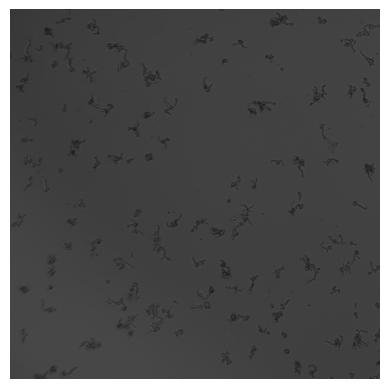

In [65]:
plt.axis('off')
plt.imshow(PIL.Image.open(one_random_image).convert("RGB"))

In [66]:
class_idx_to_sentence_descriptions

{0: ['CASPOFUNGIN whose General appearance is swelling star phenotype, swelling spores with several germination tubes around',
  'CASPOFUNGIN whose Spores shape is swelling, round, larger than usual',
  'CASPOFUNGIN whose Spores distribution is isolated spores, some overlap possible',
  'CASPOFUNGIN whose Germination tubes shape is very short, at most one branching event',
  'CASPOFUNGIN whose Germination tubes distribution is several tubes per spore, tubes grow from a few localized positions on spore surface, often two germination events at 180 degree'],
 1: ['CARBENDAZIM whose General appearance is curly germination phenotype, chaotic germination tube growth',
  'CARBENDAZIM whose Spores shape is round, smaller than usual, often hidden by tubes',
  'CARBENDAZIM whose Spores distribution is rather isolated, with a clear tendency to form clusters',
  'CARBENDAZIM whose Germination tubes shape is curly, with several branching events, short',
  'CARBENDAZIM whose Germination tubes distri

In [67]:
image_encoding = get_normalized_image_encoding(PIL.Image.open(one_random_image), backbone, preprocess,cuda_device)
#get similarity to all sentence embeddings
description_feature_vector_list = [v for k,v in sentence_description_features.items()]
description_feature_vector_list = torch.cat(description_feature_vector_list)
similarity_matrix = torch.mm(image_encoding,description_feature_vector_list.T)
similarity_matrix


tensor([[0.2339, 0.2336, 0.2517, 0.2178, 0.2338, 0.2056, 0.2389, 0.2426, 0.2083,
         0.2357, 0.2505, 0.2441, 0.2505, 0.2251, 0.2471, 0.2323, 0.2426, 0.2460,
         0.2371, 0.2349, 0.2102, 0.2377, 0.2512, 0.2177, 0.2443, 0.2216, 0.2400,
         0.2500, 0.2095, 0.2404]], device='cuda:7', dtype=torch.float16)

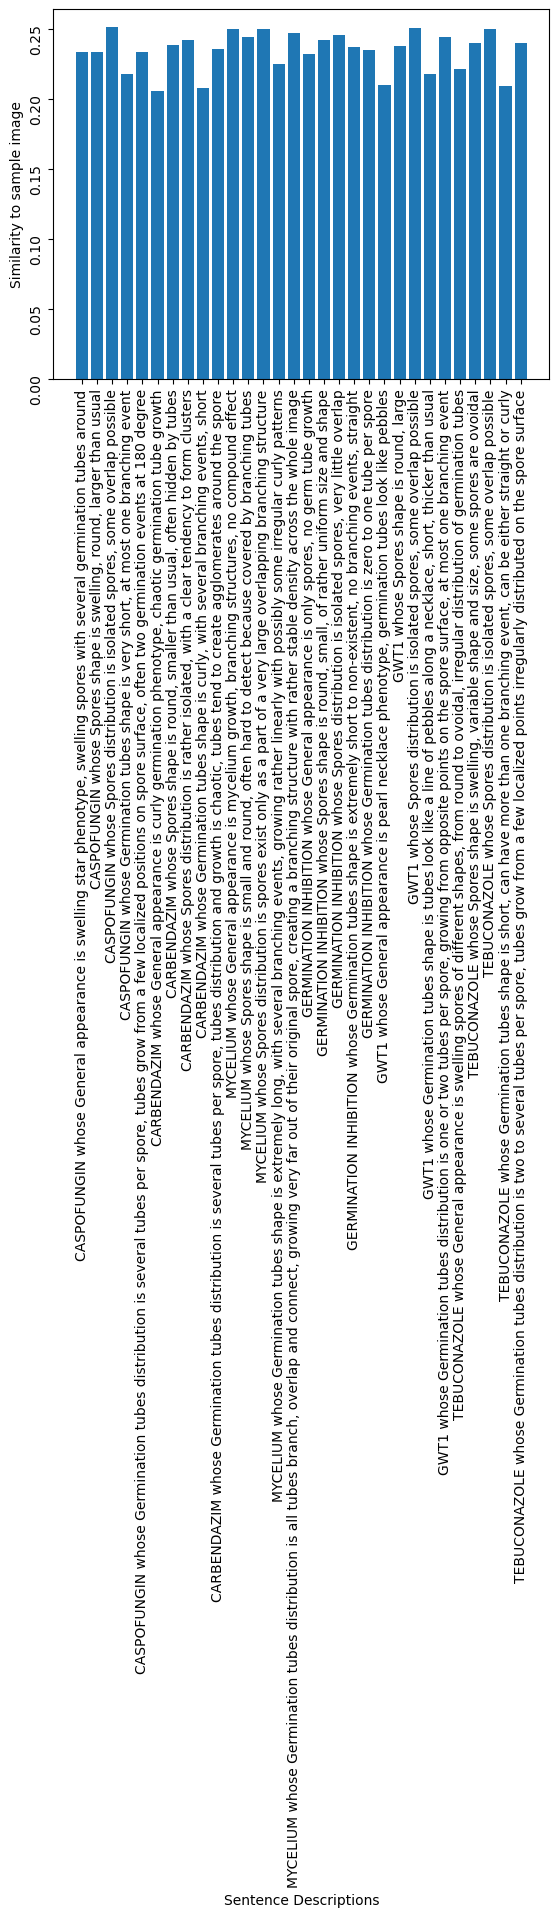

In [68]:
import matplotlib.pyplot as plt

# Create a list of labels for the x-axis
x_labels = [entry for k,v in class_idx_to_sentence_descriptions.items() for entry in v]

# Create a list of values for the y-axis
y_values = similarity_matrix.squeeze(0).tolist()

# Create a bar chart
plt.bar(x_labels, y_values)

# Add labels and title
plt.xlabel('Sentence Descriptions')
plt.ylabel('Similarity to sample image')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=90)

# Display the chart
plt.show()


/export/home/lrietdor/miniconda3/envs/Hiwi/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


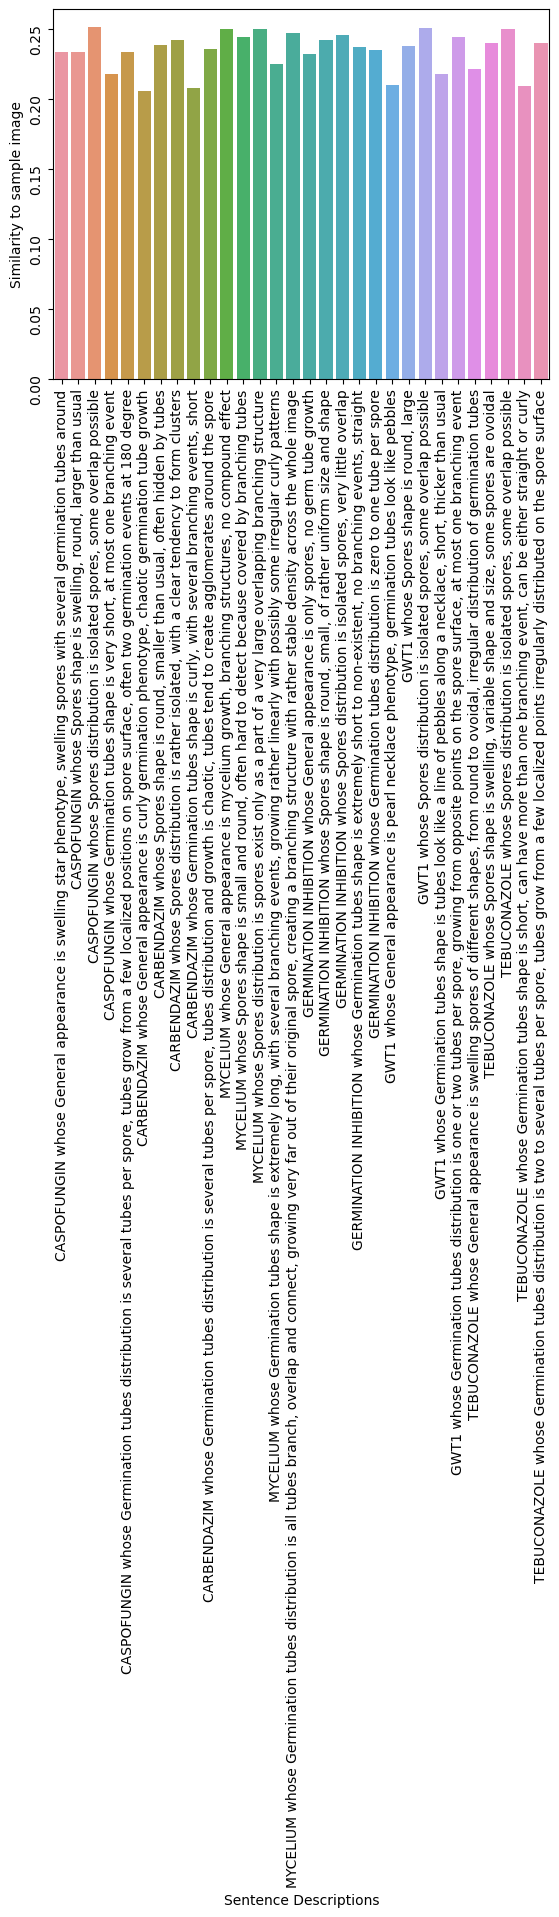

In [69]:
import seaborn as sns
# Create a list of labels for the x-axis
x_labels = [entry for k,v in class_idx_to_sentence_descriptions.items() for entry in v]

# Create a list of values for the y-axis
y_values = similarity_matrix.squeeze(0).tolist()

# Create a bar chart using seaborn
sns.barplot(x=x_labels, y=y_values)

# Add labels and title
plt.xlabel('Sentence Descriptions')
plt.ylabel('Similarity to sample image')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=90)

# Display the chart
plt.show()


## Plots

In [70]:
paths = [f"./plots_big_ds_{i}/log.txt" for i in range(16) if i!= 12]
#in each txt file parse the dictionary in the line beginning with "Using importance sampling with parameters: {'patch_size':
#and save the dictionary to a list
imp_samp_params_list = []
for path in paths:
    with open(path, "r") as f:
        acc_list = []
        append_next_line = False
        for line in f:
            if append_next_line:
                acc_list.append(eval(line.split("%")[0]))
            if "Using importance sampling with parameters" in line:
                acc_list.append(eval(line.split("parameters: ")[-1]))
            append_next_line = False
            if "Top 1 Accuracy patch-based, classname features:" in line:
                append_next_line = True
            if "Top 1 Accuracy patch-based, raw description features: " in line:
                append_next_line = True
            if ("Top 1 Accuracy patch-based, sentence description features: " in line) or "Top 1 Accuracy image-based, sentence_description_features: " in line:
                append_next_line = True
    imp_samp_params_list.append(acc_list)

In [71]:
imp_samp_params_list

[[{'patch_size': 128,
   'reduce_factor': 1,
   'scale_dog': 1,
   'grid_sep': 64,
   'map_type': 'importance',
   'patches_per_image': 7,
   'blur_samp_map': False,
   'seed': 123},
  15.0,
  26.43,
  16.9],
 [{'patch_size': 128,
   'reduce_factor': 1,
   'scale_dog': 2,
   'grid_sep': 64,
   'map_type': 'importance',
   'patches_per_image': 7,
   'blur_samp_map': False,
   'seed': 123},
  18.81,
  23.81,
  16.67],
 [{'patch_size': 128,
   'reduce_factor': 1,
   'scale_dog': 3,
   'grid_sep': 64,
   'map_type': 'importance',
   'patches_per_image': 7,
   'blur_samp_map': False,
   'seed': 123},
  18.57,
  22.62,
  16.9],
 [{'patch_size': 128,
   'reduce_factor': 1,
   'scale_dog': 4,
   'grid_sep': 64,
   'map_type': 'importance',
   'patches_per_image': 7,
   'blur_samp_map': False,
   'seed': 123},
  17.62,
  22.14,
  19.29],
 [{'patch_size': 128,
   'reduce_factor': 1,
   'scale_dog': 5,
   'grid_sep': 64,
   'map_type': 'importance',
   'patches_per_image': 7,
   'blur_samp_map': 

In [72]:
import matplotlib.pyplot as plt

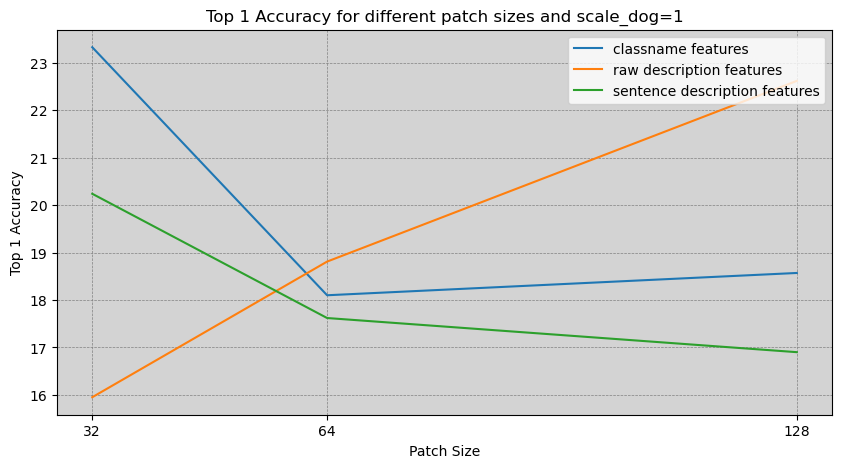

In [73]:
#for all sublists where scale_dog=1 plot the top 1 accuracy with different patch_sizes on the x axis for each of the three feature types 
entries = [entry for entry in imp_samp_params_list if entry[0]["scale_dog"]==3]
data_points_classname_features = [(entry[0]["patch_size"],entry[1]) for entry in entries]
data_points_classname_features = sorted(data_points_classname_features,key=lambda x: x[0])
data_points_classname_features = data_points_classname_features[:3] + data_points_classname_features[4:-1]
data_points_raw_des_features = [(entry[0]["patch_size"],entry[2]) for entry in entries]
data_points_raw_des_features = sorted(data_points_raw_des_features,key=lambda x: x[0])
data_points_raw_des_features = data_points_raw_des_features[:3] + data_points_raw_des_features[4:-1]
data_points_sentence_features = [(entry[0]["patch_size"],entry[3]) for entry in entries]
data_points_sentence_features = sorted(data_points_sentence_features,key=lambda x: x[0])
data_points_sentence_features = data_points_sentence_features[:3] + data_points_sentence_features[4:-1]
#now plot the datapoints
plt.plot(*zip(*data_points_classname_features), label='classname features')
plt.plot(*zip(*data_points_raw_des_features), label='raw description features')
plt.plot(*zip(*data_points_sentence_features), label='sentence description features')
plt.xlabel('Patch Size')
plt.ylabel('Top 1 Accuracy')
plt.title('Top 1 Accuracy for different patch sizes and scale_dog=1')
#only use xvalues as xticks
plt.xticks([x for x,y in data_points_classname_features])
#apply grid in grey dark
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
#change background to dark grey
plt.gca().set_facecolor('lightgrey')
#make fig bigger
plt.gcf().set_size_inches(10, 5)
plt.legend(loc='upper right')

In [74]:
paths = [f"./plots_big_ds_big_ss{i}/log.txt" for i in range(5)]
#in each txt file parse the dictionary in the line beginning with "Using importance sampling with parameters: {'patch_size':
#and save the dictionary to a list
imp_samp_params_list = []
for path in paths:
    with open(path, "r") as f:
        acc_list = []
        append_next_line = False
        for line in f:
            if append_next_line:
                acc_list.append(eval(line.split("%")[0]))
            if "Using importance sampling with parameters" in line:
                acc_list.append(eval(line.split("parameters: ")[-1]))
            append_next_line = False
            if "Top 1 Accuracy image-based, classname features:" in line:
                append_next_line = True
            if "Top 1 Accuracy image-based, raw description features: " in line:
                append_next_line = True
            if ("Top 1 Accuracy image-based, sentence description features: " in line) or "Top 1 Accuracy image-based, sentence_description_features: " in line:
                append_next_line = True
    imp_samp_params_list.append(acc_list)

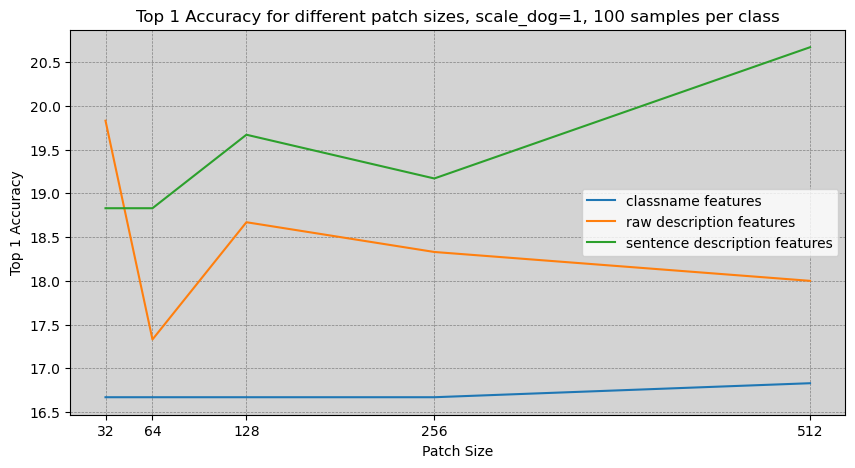

In [75]:
#for all sublists where scale_dog=1 plot the top 1 accuracy with different patch_sizes on the x axis for each of the three feature types 
entries = [entry for entry in imp_samp_params_list]
data_points_classname_features = [(entry[0]["patch_size"],entry[1]) for entry in entries]
data_points_classname_features = sorted(data_points_classname_features,key=lambda x: x[0])
data_points_raw_des_features = [(entry[0]["patch_size"],entry[2]) for entry in entries]
data_points_raw_des_features = sorted(data_points_raw_des_features,key=lambda x: x[0])
data_points_sentence_features = [(entry[0]["patch_size"],entry[3]) for entry in entries]
data_points_sentence_features = sorted(data_points_sentence_features,key=lambda x: x[0])
#now plot the datapoints
plt.plot(*zip(*data_points_classname_features), label='classname features')
plt.plot(*zip(*data_points_raw_des_features), label='raw description features')
plt.plot(*zip(*data_points_sentence_features), label='sentence description features')
plt.xlabel('Patch Size')
plt.ylabel('Top 1 Accuracy')
plt.title('Top 1 Accuracy for different patch sizes, scale_dog=1, 100 samples per class')
#only use xvalues as xticks
plt.xticks([x for x,y in data_points_classname_features])
#apply grid in grey dark
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
#change background to dark grey
plt.gca().set_facecolor('lightgrey')
#make fig bigger
plt.gcf().set_size_inches(10, 5)
plt.legend(loc='right')